In [1]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# int mappings 
chrs = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chrs, 1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# ----------- Attempting my own from the paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [5]:
# Generate input / output pairs
block_size = 3

X, Y = [], []

for w in words[:]:
    # print(w)

    context = [0] * block_size 
    for ch in (w + '.'):
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

# for x, y in zip(X,Y):
#     print(f'{x} -----> {y}')

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f'Num of training samples: {X.shape[0]}')

Num of training samples: 228146


In [6]:
# Build the network: y = b + U*tanh(d+Hx)
feature_dimensions=10 
hidden_units=200

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((len(stoi),feature_dimensions), requires_grad=True, generator=g) # e.g., C is (27,2); if X is (5,3) then C[X] is (5,3,2)
H = torch.randn((block_size*feature_dimensions,hidden_units), requires_grad=True, generator=g) # e.g., (3*2,20)
d = torch.randn(hidden_units, requires_grad=True, generator=g) # e.g., (20,)
U = torch.randn((hidden_units,len(stoi)), requires_grad=True, generator=g) # e.g., (20, 27)
b = torch.randn(len(stoi), requires_grad=True, generator=g) # e.g., (27,)

parameters = [C, H, d, U, b]
print(f'Total params: {sum(p.nelement() for p in parameters)}')

Total params: 11897


In [7]:
# fwd pass 
h = (C[X].view(X.shape[0],-1) @ H) + d
logits = (h.tanh() @ U) + b
counts = logits.exp()
probs = counts/counts.sum(axis=1, keepdims=True)

In [8]:
# loss function 
prob = probs[torch.arange(X.shape[0]),Y]
loss = -prob.log().mean()
print (f'loss: {loss.item():.4f}')

loss: 26.0063


In [9]:
# reset grad
for p in parameters:
    p.grad = None

In [10]:
# backward
loss.backward()

In [11]:
# parameter adjust 
for p in parameters:
    p.data += -0.1*p.grad

In [12]:
for step in range(20000):
    # fwd pass 
    h = (C[X].view(X.shape[0],-1) @ H) + d
    logits = (h.tanh() @ U) + b
    counts = logits.exp()
    probs = counts/counts.sum(axis=1, keepdims=True)
    
    # loss function 
    prob = probs[torch.arange(X.shape[0]),Y]
    loss = -prob.log().mean()
    if step % 100 == 0: 
        print (f'Step: {step}, loss: {loss.item():.4f}')
        
    # reset grad
    for p in parameters:
        p.grad = None
        
    # backward
    loss.backward()
    
    # parameter adjust 
    for p in parameters:
        p.data += -0.1*p.grad

Step: 0, loss: 24.3454


KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = (emb.view(1,-1) @ H) + d
        logits = (h.tanh() @ U) + b
        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

In [102]:
# -------------- Decent result, loss @ 2.6 after ~2100 iterations across entire training set but missed a few things:
#     * Creating training, validation and test sets 
#     * Creating minibatches from the training set 
#     * Adapting the learning rate over steps 

# --------------- Retrying again with those adjustments 

In [103]:
import torch, torch.nn.functional as F
import numpy 
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Create the vocabulary 

words = open('names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chrs,1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

stoi, itos

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'})

In [105]:
# Generate the samples 

block_size = 4

import random
random.seed(42)

random.shuffle(words) 
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

def create_samples(words):
    x, y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            i = stoi[ch]
            x.append(context)
            y.append(i)
            context=context[1:]+[i]
    return torch.tensor(x), torch.tensor(y)

Xtr, Ytr = create_samples(words[:n1])
Xval, Yval = create_samples(words[n1:n2])
Xtst, Ytst = create_samples(words[n2:])

print(f'Training samples: {Xtr.shape[0]}')
print(f'Validation samples: {Xval.shape[0]}')
print(f'Testing samples: {Xtst.shape[0]}')

Training samples: 182625
Validation samples: 22655
Testing samples: 22866


In [106]:
# Create the NN
g = torch.Generator().manual_seed(2147483647)

features = 10
hidden_units = 200

# y = b + U*tanh(d + Hx)
C = torch.randn((len(stoi),features), generator=g)
H = torch.randn((block_size*features,hidden_units), generator=g)
d = torch.randn(hidden_units, generator=g)
U = torch.randn((hidden_units,len(stoi)), generator=g)
b = torch.randn(len(stoi), generator=g)

parameters = [C, H, d, U, b]
for p in parameters:
    p.requires_grad = True
print(f'Total params: {sum(p.nelement() for p in parameters)}')

Total params: 13897


In [108]:
stepi, lossi = [], []

In [109]:
minibatch_sz = 64
iterations = 200000

for step in range(iterations):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (minibatch_sz,))
    emb = C[Xtr[ix]]

    # fwd pass 
    h = torch.tanh((emb.view(minibatch_sz,-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
    logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # adjust params
    lr = 0.1 if step < iterations/2 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if step % (iterations/10) == 0:
        print(f'Step: {step}, loss: {loss.item():.4f}')
        
    stepi.append(step)
    lossi.append(loss.log10().item())

Step: 0, loss: 25.9905
Step: 20000, loss: 2.0838
Step: 40000, loss: 2.5061
Step: 60000, loss: 2.1868
Step: 80000, loss: 2.3783
Step: 100000, loss: 2.3003
Step: 120000, loss: 2.0581
Step: 140000, loss: 2.1322
Step: 160000, loss: 2.0164
Step: 180000, loss: 2.0070


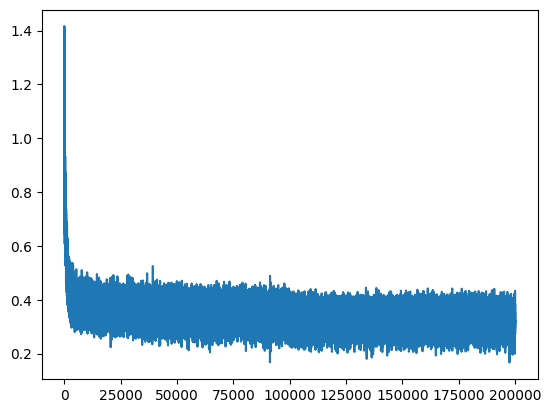

In [110]:
plt.plot(stepi, lossi)

In [111]:
emb = C[Xtr]

# fwd pass 
h = torch.tanh((emb.view(Xtr.shape[0],-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1157, grad_fn=<NllLossBackward0>)

In [112]:
emb = C[Xval]

# fwd pass 
h = torch.tanh((emb.view(Xval.shape[0],-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
loss = F.cross_entropy(logits,Yval)
loss

tensor(2.1500, grad_fn=<NllLossBackward0>)

In [113]:
emb = C[Xtst]

# fwd pass 
h = torch.tanh((emb.view(Xtst.shape[0],-1) @ H) + d) # (32,6) @ (6,20) + (20) = (32,20)
logits = (h @ U) + b # (32,20) @ (20,27) + (27) = (32,27)
loss = F.cross_entropy(logits,Ytst)
loss

tensor(2.1441, grad_fn=<NllLossBackward0>)

/var/folders/5w/mnhdn3yn1dlc6t15hxlzfy_r0000gn/T/ipykernel_7146/3431613057.py:4: UserWarning: features <> 2
  warnings.warn('features <> 2')


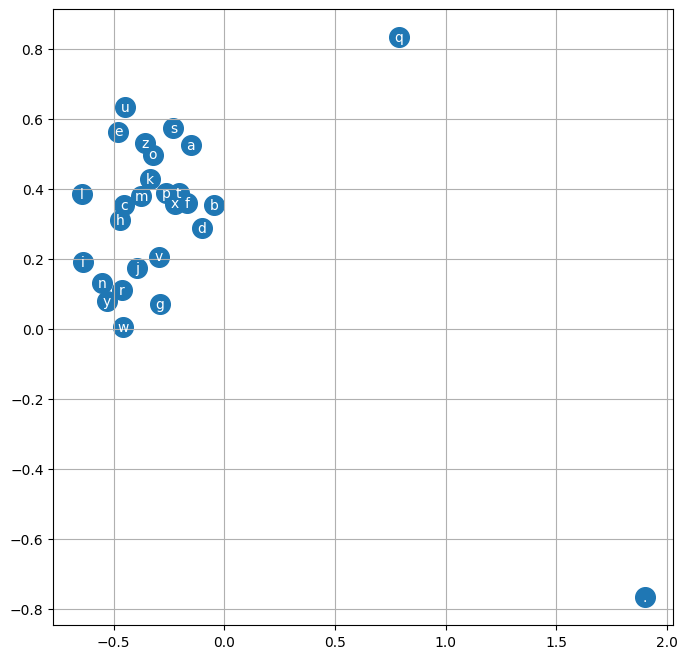

In [122]:
# Doesn't make sense if features <> 2
import warnings
if (features != 2): 
    warnings.warn('features <> 2') 

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [114]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ H + d)
        logits = h @ U + b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmah.
ambriell.
kimra.
rehtyn.
kanden.
jazoneefa.
esric.
kaqui.
nelonia.
chaiir.
kaleigh.
hama.
dinder.
juzs.
lilea.
jadbi.
watthon.
jaryn.
kakae.
pirray.


## Lessons from this part:
* Minibatch - Better to have estimated direction of the gradient and take a lot of fast steps in that direction, vs. estimating the exact direction of the gradient and take a few steps.
    * In practice, this means a minibatch. 
    * You can estimate the exact direction of the gradient across the entire data set and then backprop to head in that direction. But each fwd_pass takes a long time, and you take fewer steps even if each step is in the exact right direction. 
    * But in practice, it's better to have an estimated direction of the gradient with a minibatch, take a quick, even if inaccurate step, and iterate faster.

* Learning rate and decaying it - Understand how loss varies with different learning rates
    * To learn, first manually test the upper and lower limits of acceptable losses 
    * Next, iterate over the LRs (array with exponential change on LR between lower and upper limits) and see how loss varies across those. Pick the one where the loss is the lowest. 
    * Once you have trained a few iterations on that LR and the loss is plateauing, then decay the learning rate by 10 i.e., 0.1 to 0.01  

* Over/under-fitting: Compare losses of the training vs. dev set: 
    * If the loss_training ~= loss_dev, then you are likely underfitting. That is, the model either doesn't have enough capacity to learn the training set, or hasn't been trained enough to tell the difference between training vs. dev sets. 
    * If the loss_training << loss_dev, then you are likely overfitting. That is, the model has memorized the training set and isn't able to generalize to data it hasn't seen. 
    * If the loss_traing >> loss_dev - well, that doesn't really make sense. Maybe you got super lucky and it won't happen again :) 